In [12]:
import numpy as np
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

# Define constants
img_size = 64
frames_per_clip = 16
num_segments = 3
batch_size = 8
epochs = 10

# Function to load and preprocess videos
def load_video_frames(video_path, img_size, frames_per_clip):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < frames_per_clip:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame)
    
    while len(frames) < frames_per_clip:
        frames.append(frames[-1])
    
    cap.release()
    return np.array(frames)

def load_video_segments(video_path, img_size, frames_per_clip, num_segments):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame)
    
    cap.release()
    
    total_frames = len(frames)
    frames_required = frames_per_clip * num_segments
    
    if total_frames < frames_required:
        frames.extend([frames[-1]] * (frames_required - total_frames))
    
    segment_length = frames_required // num_segments
    segments = []
    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length
        segments.append(frames[start:end])
    
    return np.array(segments)

def load_videos_from_directory(directory, label, img_size, frames_per_clip, num_segments):
    video_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.avi')]
    videos = []
    labels = []
    for video_file in video_files:
        segments = load_video_segments(video_file, img_size, frames_per_clip, num_segments)
        videos.extend(segments)
        labels.extend([label] * len(segments))
    return np.array(videos), np.array(labels), len(video_files)

# Load videos
blepharospasm_videos, blepharospasm_labels, num_blepharospasm_videos = load_videos_from_directory('D:\\harsh\\Blepharospasm\\Bleph2', 1, img_size, frames_per_clip, num_segments)
normal_videos, normal_labels, num_normal_videos = load_videos_from_directory('D:\\harsh\\Blepharospasm\\Norm2', 0, img_size, frames_per_clip, num_segments)

# Combine dataset
X = np.concatenate([blepharospasm_videos, normal_videos], axis=0)
y = np.concatenate([blepharospasm_labels, normal_labels], axis=0)

# Split videos into training and testing sets (75% training, 25% testing)
video_labels = np.concatenate([
    np.array([1] * num_blepharospasm_videos),
    np.array([0] * num_normal_videos)
])

video_files = np.array([os.path.join('D:\\harsh\\Blepharospasm\\Bleph2', f) for f in os.listdir('D:\\harsh\\Blepharospasm\\Bleph2') if f.endswith('.avi')] +
                       [os.path.join('D:\\harsh\\Blepharospasm\\Norm2', f) for f in os.listdir('D:\\harsh\\Blepharospasm\\Norm2') if f.endswith('.avi')])

train_files, test_files = train_test_split(video_files, test_size=0.25, random_state=42, stratify=video_labels)
train_labels = video_labels[np.isin(video_files, train_files)]
test_labels = video_labels[np.isin(video_files, test_files)]

# Load training and testing data
X_train = np.concatenate([load_video_segments(f, img_size, frames_per_clip, num_segments) for f in train_files], axis=0)
y_train = np.concatenate([np.array([label] * num_segments) for label in train_labels], axis=0)

X_test = np.concatenate([load_video_segments(f, img_size, frames_per_clip, num_segments) for f in test_files], axis=0)
y_test = np.concatenate([np.array([label] * num_segments) for label in test_labels], axis=0)

# Define the 3D CNN model
input_shape = (frames_per_clip, img_size, img_size, 3)

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 16, 64, 64, 32)    2624      
                                                                 
 max_pooling3d_11 (MaxPooli  (None, 8, 32, 32, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_12 (Conv3D)          (None, 8, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 4, 16, 16, 64)     0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 4, 16, 16, 128)    221312    
                                                                 
 max_pooling3d_13 (MaxPooli  (None, 2, 8, 8, 128)     

In [13]:
# Evaluate video-wise accuracy
def classify_video_segments(video_segments, model):
    predictions = []
    for segment in video_segments:
        segment = segment[np.newaxis, ...]
        prediction = model.predict(segment)
        predictions.append(prediction[0][0])
    final_prediction = np.mean(predictions) > 0.5
    return int(final_prediction)

def classify_videos(X_data, y_data, model, frames_per_clip, num_segments):
    y_true = []
    y_pred = []
    
    num_videos = len(X_data) // num_segments
    for i in range(num_videos):
        start = i * num_segments
        end = start + num_segments
        video_segments = X_data[start:end]
        
        true_label = y_data[start]  # All segments of a video should have the same true label
        final_class = classify_video_segments(video_segments, model)
        
        y_true.append(true_label)
        y_pred.append(final_class)
    
    return np.array(y_true), np.array(y_pred)

# Train and evaluate the model
train_true, train_pred = classify_videos(X_train, y_train, model, frames_per_clip, num_segments)
test_true, test_pred = classify_videos(X_test, y_test, model, frames_per_clip, num_segments)

1/1 [==============================] - 0s 51ms/step


Training Set Confusion Matrix:
[[42 13]
 [ 8 45]]

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        55
           1       0.78      0.85      0.81        53

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.81      0.81      0.81       108

Test Set Confusion Matrix:
[[11  8]
 [ 6 11]]

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61        19
           1       0.58      0.65      0.61        17

    accuracy                           0.61        36
   macro avg       0.61      0.61      0.61        36
weighted avg       0.61      0.61      0.61        36

Training Accuracy: 0.8056
Test Accuracy: 0.6111


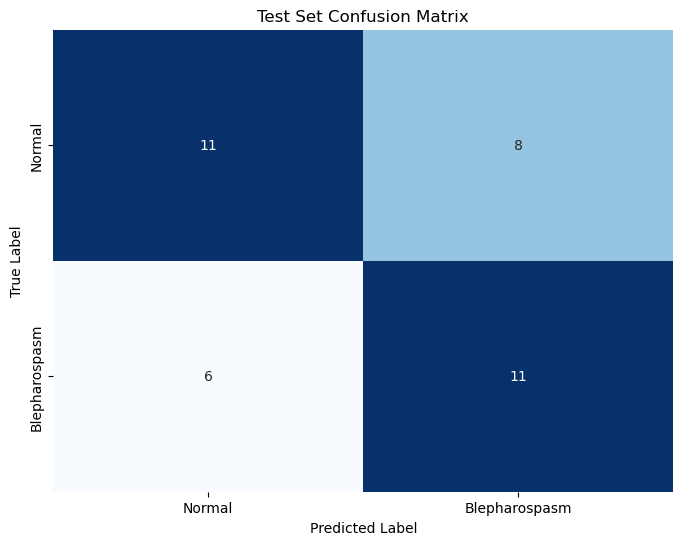

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix and Classification Report
print('Training Set Confusion Matrix:')
cm_train = confusion_matrix(train_true, train_pred)
print(cm_train)
print('\nTraining Set Classification Report:')
print(classification_report(train_true, train_pred))

print('Test Set Confusion Matrix:')
cm_test = confusion_matrix(test_true, test_pred)
print(cm_test)
print('\nTest Set Classification Report:')
print(classification_report(test_true, test_pred))

# Calculate and print accuracy
train_accuracy = accuracy_score(train_true, train_pred)
test_accuracy = accuracy_score(test_true, test_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot Confusion Matrix for Test Set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Normal', 'Blepharospasm'], yticklabels=['Normal', 'Blepharospasm'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Set Confusion Matrix')
plt.show()

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

# Define constants
img_size = 64  # Resolution to which each frame will be resized
frames_per_clip = 16  # Number of frames per video segment
embedding_size = 64  # Size of the embedding layer
batch_size = 8
epochs = 10

# Function to load and preprocess videos
def load_video_frames(video_path, img_size, frames_per_clip):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < frames_per_clip:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame)
    
    while len(frames) < frames_per_clip:
        frames.append(frames[-1])
    
    cap.release()
    return np.array(frames)

# Function to load videos from directories
def load_videos_from_directory(directory, label, img_size, frames_per_clip):
    video_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.avi')]
    videos = []
    video_names = []
    labels = []
    for video_file in video_files:
        video = load_video_frames(video_file, img_size, frames_per_clip)
        videos.append(video)
        video_name = os.path.splitext(os.path.basename(video_file))[0]  # Get video name without extension
        video_names.append(video_name)
        labels.append(label)
    return np.array(videos), video_names, np.array(labels)

# Load Blepharospasm videos
blepharospasm_videos, blepharospasm_names, blepharospasm_labels = load_videos_from_directory('D:\\harsh\\Blepharospasm\\Bleph2', 1, img_size, frames_per_clip)

# Load Normal videos
normal_videos, normal_names, normal_labels = load_videos_from_directory('D:\\harsh\\Blepharospasm\\Norm2', 0, img_size, frames_per_clip)

# Combine all the videos and labels
all_videos = np.concatenate([blepharospasm_videos, normal_videos], axis=0)
all_video_names = blepharospasm_names + normal_names
all_labels = np.concatenate([blepharospasm_labels, normal_labels], axis=0)

# Normalize the pixel values
all_videos = all_videos / 255.0

# Create the 3D CNN model
input_shape = (frames_per_clip, img_size, img_size, 3)

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Flatten(),
    Dense(embedding_size, activation='relu', name='embedding_layer'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
X_train, X_test, y_train, y_test = train_test_split(all_videos, all_labels, test_size=0.25, random_state=42)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Create a new model that outputs the embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('embedding_layer').output)

# Prepare the CSV file for embeddings
output_csv_path = r'D:\\harsh\\Blepharospasm\\video_embeddings.csv'
header = ['video'] + [f'embed_{i+1}' for i in range(embedding_size)] + ['label']
with open(output_csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    # Iterate through all videos to save embeddings
    for video, name, label in zip(all_videos, all_video_names, all_labels):
        video = np.expand_dims(video, axis=0)  # Expand dimensions to match model input
        embeddings = embedding_model.predict(video)
        embeddings = embeddings.flatten()
        row = [name] + embeddings.tolist() + [label]
        writer.writerow(row)

print(f"Embeddings saved to {output_csv_path}")


Epoch 1/10
11/11 [==============================] - 13s 736ms/step - loss: 0.8298 - accuracy: 0.5349 - val_loss: 0.6831 - val_accuracy: 0.6818
Epoch 2/10
11/11 [==============================] - 7s 666ms/step - loss: 0.6979 - accuracy: 0.5930 - val_loss: 0.6310 - val_accuracy: 0.8636
Epoch 3/10
11/11 [==============================] - 7s 671ms/step - loss: 0.6307 - accuracy: 0.6628 - val_loss: 0.7443 - val_accuracy: 0.5455
Epoch 4/10
11/11 [==============================] - 14s 1s/step - loss: 0.5710 - accuracy: 0.6744 - val_loss: 0.4609 - val_accuracy: 0.8636
Epoch 5/10
11/11 [==============================] - 11s 971ms/step - loss: 0.5946 - accuracy: 0.6512 - val_loss: 0.5148 - val_accuracy: 0.8182
Epoch 6/10
11/11 [==============================] - 9s 857ms/step - loss: 0.6154 - accuracy: 0.6860 - val_loss: 0.4591 - val_accuracy: 0.8636
Epoch 7/10
11/11 [==============================] - 7s 669ms/step - loss: 0.5102 - accuracy: 0.7093 - val_loss: 0.3724 - val_accuracy: 0.8636
Epoch 

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import numpy as np
import cv2
import os
import csv

# Constants
img_size = 64  # Resize frames to this size
frames_per_clip = 16  # Number of frames per video segment
embedding_size = 128  # Size of the embeddings (must match the number of neurons in the embedding layer)
output_csv = 'D:\\harsh\\Blepharospasm\\video_embeddings2.csv'  # Output CSV file

# Function to load and preprocess video segments
def load_video_segments(video_path, img_size, frames_per_clip, num_segments=3):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    segment_length = frames_per_clip * num_segments
    
    if total_frames < segment_length:
        print(f"Warning: {video_path} has fewer frames than required. Duplicating last frame.")
    
    frames = []
    segments = []
    while len(segments) < num_segments:
        ret, frame = cap.read()
        if not ret:  # If the video ends, repeat the last frame
            frame = frames[-1] if frames else np.zeros((img_size, img_size, 3), dtype=np.uint8)
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame)
        
        # When enough frames are collected for one segment
        if len(frames) == frames_per_clip:
            segments.append(np.array(frames))
            frames = []
    
    cap.release()
    
    return segments

# Function to process videos and calculate embeddings
def process_directory(directory, label, model):
    video_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.avi')]
    all_embeddings = []
    
    for video_file in video_files:
        video_name = os.path.splitext(os.path.basename(video_file))[0]
        segments = load_video_segments(video_file, img_size, frames_per_clip)
        
        # Initialize a list to hold all segment embeddings for a single video
        video_embeddings = []
        
        for segment in segments:
            segment = np.expand_dims(segment, axis=0)  # Add batch dimension
            segment = segment / 255.0  # Normalize pixel values
            
            # Get embedding for the segment
            embedding = model.predict(segment)[0]
            video_embeddings.extend(embedding)  # Concatenate embeddings
        
        # Ensure that the vector is exactly 384-dimensional (3 segments * 128 dimensions each)
        if len(video_embeddings) == embedding_size * 3:
            all_embeddings.append([video_name] + video_embeddings + [label])
        else:
            print(f"Warning: {video_name} does not have a complete 384-dimensional embedding. Skipping.")
    
    return all_embeddings

# Build the 3D CNN model
input_shape = (frames_per_clip, img_size, img_size, 3)  # e.g., (16, 64, 64, 3)

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Flatten(),
    Dense(embedding_size, activation='relu', name='embedding_layer'),  # Embedding layer
    Dropout(0.5)
    # No final classification layer
])

# Create a model up to the embedding layer
embedding_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('embedding_layer').output)

# Process videos in both directories
blepharospasm_embeddings = process_directory('D:\\harsh\\Blepharospasm\\Bleph2', 1, embedding_model)
normal_embeddings = process_directory('D:\\harsh\\Blepharospasm\\Norm2', 0, embedding_model)

# Combine all embeddings
all_embeddings = blepharospasm_embeddings + normal_embeddings

# Save the embeddings to a CSV file
header = ['video'] + [f'embedding_{i+1}' for i in range(embedding_size * 3)] + ['label']
with open(output_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(all_embeddings)

print(f"Embeddings saved to {output_csv}")


1/1 [==============================] - 0s 67ms/step
Embeddings saved to D:\harsh\Blepharospasm\video_embeddings2.csv


## Classification using 3D CNN Embeddings 

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

In [60]:
data = pd.read_csv(r"C:\\Users\\harsh\\Downloads\\rdclb.csv")

In [61]:
data.head(5)

,79,58,97,11556,2074,127,4.4,16.3,72,33,...,0.0466707,0.168606,-0.125426,-0.0351613,-0.0731265,0.212,0.02,0.768,0.9986,0.183
0,97,1,3,672,112,5,4.7,22.4,52,79,...,0.058441,-0.227890,-0.052269,0.113221,-0.175180,0.159,0.000,0.841,0.9097,1
1,95,2,5,969,150,9,5.3,16.7,61,71,...,0.109198,-0.111316,0.107089,0.028658,0.125803,0.132,0.052,0.815,0.9590,0
2,98,1,3,1208,217,14,4.2,15.5,76,56,...,0.005936,0.087896,-0.025581,0.066143,0.056845,0.022,0.096,0.882,-0.8257,1
3,84,15,21,3029,539,33,4.3,16.3,78,46,...,0.161667,0.282885,0.212748,0.116077,-0.019821,0.143,0.074,0.783,0.9330,0
4,95,2,3,776,122,8,5.1,15.3,50,69,...,0.054474,0.260409,-0.267011,-0.101530,-0.031509,0.167,0.089,0.744,0.8555,1


In [49]:
#drop subfolder_name and save to new df
final_data = data.drop("video", axis = 1)

In [50]:
final_data.head(5)

,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,...,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,embedding_384,label
0,0.181816,0.057779,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.077874,0.000000,...,0.057492,0.098769,0.009716,0.0,0.056469,0.051170,0.0,0.021602,0.053250,1
1,0.191542,0.031380,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.064354,0.016414,...,0.098108,0.095290,0.000000,0.0,0.027545,0.064191,0.0,0.000000,0.058973,1
2,0.027673,0.000000,0.000604,0.0,0.048718,0.0,0.0,0.112900,0.029905,0.143411,...,0.117180,0.119241,0.162806,0.0,0.023622,0.033411,0.0,0.000000,0.000000,1
3,0.006570,0.000000,0.000000,0.0,0.059976,0.0,0.0,0.034572,0.044726,0.116715,...,0.058589,0.016879,0.251307,0.0,0.100520,0.087161,0.0,0.000000,0.000000,1
4,0.063664,0.000000,0.000000,0.0,0.066757,0.0,0.0,0.090237,0.040281,0.053307,...,0.125246,0.098757,0.188649,0.0,0.110581,0.013414,0.0,0.000000,0.125440,1


In [62]:
# Take last coloumn as y and rest as X
X = final_data.iloc[:, :-1]
y = final_data.iloc[:, -1]

In [51]:
# Assuming 'target' is the column you want to predict
X = data.drop('label', axis=1)  # Features
y = data['label']  # Target variable

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [64]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)


In [65]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)


In [66]:

# Standardize the data
scaler = StandardScaler()

# Define models to test
models = {
    'RandomForest': RandomForestClassifier(max_depth=10, n_estimators=100),
    'SVM': SVC(gamma=0.1, kernel='rbf'),
    'LogisticRegression': LogisticRegression(C=10, solver='liblinear'),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=30),
    'MLP': MLPClassifier(activation='relu', hidden_layer_sizes=(100,), solver='sgd', max_iter=2000),
    'XGBoost': XGBClassifier(learning_rate=0.1,n_estimators=100)
}

# Create a pipeline for each model and use regularized cross-validation to evaluate the model

pipelines = {name: Pipeline([ ('model', model)]) for name, model in models.items()}


In [67]:
# Example parameter grids (customize these based on your requirements)
param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'SVM': {
        'model__C': [0.1, 1, 10,100,150],
        'model__gamma': [1, 0.1, 0.01],
        'model__kernel': ['rbf', 'linear']
    },
    'LogisticRegression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'DecisionTree': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 1]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu', 'tanh'],
        'model__solver': ['adam', 'sgd']
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 1]
    }
}

In [68]:
# Perform GridSearchCV for each model
best_estimators = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=rkf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f'{name} best parameters: {grid_search.best_params_}')
    print(f'{name} best score: {grid_search.best_score_}')

RandomForest best parameters: {'model__max_depth': 30, 'model__n_estimators': 200}
RandomForest best score: 0.6861904761904762
SVM best parameters: {'model__C': 100, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
SVM best score: 0.7434632034632034
LogisticRegression best parameters: {'model__C': 10, 'model__solver': 'liblinear'}
LogisticRegression best score: 0.6567099567099567
KNN best parameters: {'model__n_neighbors': 3, 'model__weights': 'uniform'}
KNN best score: 0.7506060606060605
DecisionTree best parameters: {'model__max_depth': 30, 'model__min_samples_split': 10}
DecisionTree best score: 0.6077056277056276
MLP best parameters: {'model__activation': 'relu', 'model__hidden_layer_sizes': (50,), 'model__solver': 'adam'}
MLP best score: 0.7008658008658007
XGBoost best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 300}
XGBoost best score: 0.649090909090909


Evaluation for RandomForest:
Accuracy: 0.6944444444444444
Precision: 0.696938424492604
Recall: 0.6944444444444444
F1 Score: 0.6951566951566952


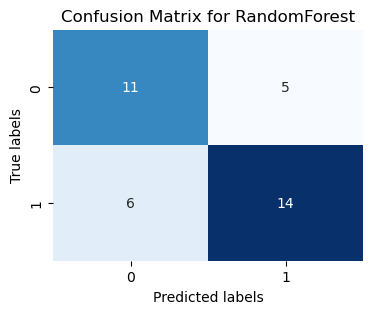

Evaluation for SVM:
Accuracy: 0.6944444444444444
Precision: 0.7055383556931544
Recall: 0.6944444444444444
F1 Score: 0.6951522951522952


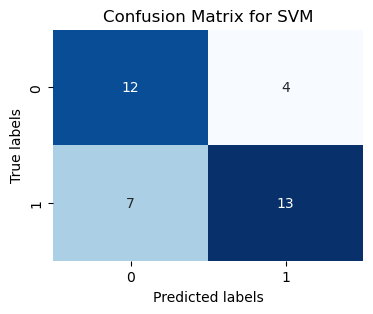

Evaluation for LogisticRegression:
Accuracy: 0.6944444444444444
Precision: 0.696938424492604
Recall: 0.6944444444444444
F1 Score: 0.6951566951566952


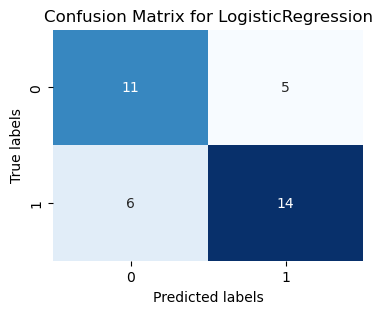

Evaluation for KNN:
Accuracy: 0.3333333333333333
Precision: 0.3416666666666667
Recall: 0.3333333333333333
F1 Score: 0.33333333333333326


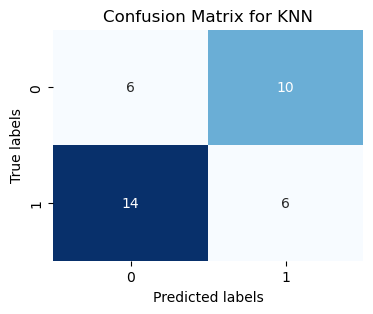

Evaluation for DecisionTree:
Accuracy: 0.6111111111111112
Precision: 0.6172839506172839
Recall: 0.6111111111111112
F1 Score: 0.6123151014791881


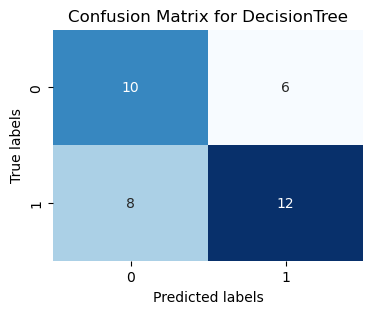

Evaluation for MLP:
Accuracy: 0.6666666666666666
Precision: 0.6833333333333333
Recall: 0.6666666666666666
F1 Score: 0.6666666666666665


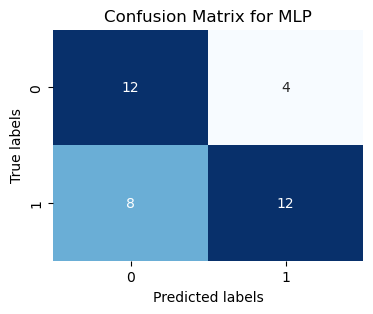

Evaluation for XGBoost:
Accuracy: 0.6111111111111112
Precision: 0.6111111111111112
Recall: 0.6111111111111112
F1 Score: 0.6111111111111112


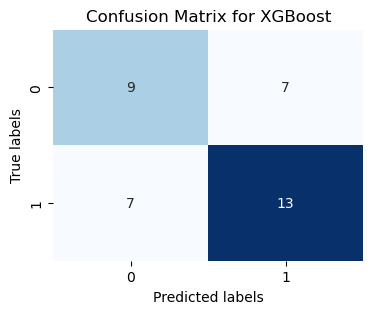

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate model
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Evaluation for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Plot confusion matrix
    cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Evaluate each best model
for name, model in best_estimators.items():
    evaluate_model(name, model, X_test, y_test)
